# Econometría Aplicada II
## Tarea 1
Importar librerías

In [1]:
%%capture

# Don't crash
from IPython import get_ipython

# Clonar repo si estamos en colab
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/ArturoSbr/EmtrAp2-hw01
    # !pip install scipy==1.7.3
    %cd EmtrAp2-hw01/cod

# Libs
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.api import OLS
from matplotlib import pyplot as plt

Importar datos

In [2]:
d1 = pd.read_csv('../dat/baseline.csv')
d2 = pd.read_csv('../dat/endline.csv')
d3 = pd.read_csv('../dat/completa.csv')

### 1.1. Balance
Tabla de balance por grupo de acuerdo a `T_nap`

In [3]:
# Seleccionar 10 variables basales
X = ['time_in_office','age_','female_','education_','sleep_report','no_of_children_','act_inbed',
     'an_12_number_of_awakenings','an_13_average_awakening_length','unemployed']

# Inicializar lista
d = []

# Medias de variables basales
for x in X:
    # Grupos
    b, a = d1.groupby('T_nap')[x].apply(np.array)
    # t-test
    test = stats.ttest_ind(a=a, b=b, equal_var=False, nan_policy='omit')
    # Agregar a lista
    d.append([x] + list(test))

# A tabla
t = pd.DataFrame(data=d, columns=['var','t','p']).sort_values('var')
t['var'] = t['var'].str.replace('_',' ')
t.round(3)

,var,t,p
6,act inbed,1.255,0.210
1,age,-0.249,0.804
7,an 12 number of awakenings,0.780,0.436
8,an 13 average awakening length,0.111,0.912
3,education,-1.296,0.196
2,female,-0.034,0.973
5,no of children,0.533,0.594
4,sleep report,1.125,0.262
0,time in office,-0.246,0.806
9,unemployed,0.491,0.624


In [4]:
# To latex
# print(t.set_index('var').to_latex(float_format='%.3f', caption='Balance sobre 10 covariables'))

Todos los p-values de las pruebas de diferencia de medias son mayores a 0.1. Esto significa que para toda variable independiente $X_j$, no podemos rechazar la hipótesis nula $\mu_{X_j}^C = \mu_{X_j}^T$. Las pruebas individuales sugieren que no existe ninguna diferencia entra las medias del grupo de control y el grupo de tratamiento.

Para evaluar la significancia de manera conjunta, uso el siguiente modelo de probabilidad lineal:
$$T_i = \beta_0 + X_i^T \beta + U_i$$
donde $X_i^T$ contiene todos los controles evaluados en la prueba anterior.

La prueba de hipótesis para determinar si al menos una de las variables indepentientes está relacionada con la asignación a tratamiento es:
$$H_0: \beta_1 = 0$$
$$H_1: \text{Al menos un coeficiente es distinto de cero}$$

In [5]:
# T_nap en función de controles
m = OLS(endog=d1['T_nap'], exog=d1[X].assign(const = 1)).fit()

# Tabla de resumen
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  T_nap   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.5731
Date:                Thu, 19 May 2022   Prob (F-statistic):              0.836
Time:                        09:38:00   Log-Likelihood:                -297.54
No. Observations:                 414   AIC:                             617.1
Df Residuals:                     403   BIC:                             661.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
time_in_offi

Al igual que en las diferencias de medias, todos los coeficientes estimados del modelo de probabilidad lineal tienen p-values menores a 0.1. Por ende, ninguno de las variables independientes tiene significancia individual para determinar la asignación a tratamiento.

La prueba que nos interesa se ve reflejada en el estadístico $F$. La prueba de significancia conjunta tiene un p-value de 0.882. Es decir, no hay evidencia de que alguno de los coeficientes sea distinto de cero.

Como conclusión, parece que el tratamiento sí fue asignado de manera aleatoria con base en los 10 controles que elegí.

### 1.2. Efectos de tratamiento
Efectos de tratamiento sobre la productividad de los trabajadores.

#### a) Estimadores de Neyman

In [6]:
# Función para estimador de Neyman
def neyman(frame, treatment_col, values_col):
    # Arreglos C y T
    m = frame[[treatment_col,values_col]].notna().all(axis=1)
    a, b = frame[m].groupby(treatment_col)[values_col].apply(np.array)
    # Diferencia de medias
    tau = np.mean(b) - np.mean(a)
    # Error estándar sobre-estimado
    bse = np.sqrt(np.var(a, ddof=1) / len(a) + np.var(b, ddof=1) / len(b))
    # t-stat
    t = tau / bse
    # p-value
    p = 2 * (1 - stats.norm().cdf(np.abs(t)))
    return [treatment_col, tau, bse, t, p]

# Diferencia de Neyman
prod_ney = neyman(d2, 'T_nap', 'productivity')
print(f'Prueba de Neyman sobre productividad:\n{prod_ney}')

Prueba de Neyman sobre productividad:
['T_nap', -170.53711387267913, 177.8423473054588, -0.9589229812614184, 0.3375975464907819]


#### b) Estimadores OLS sin controles

In [7]:
m = OLS(endog=d2['productivity'], exog=d2.assign(const = 1)[['const','T_nap']], missing='drop')
m = m.fit(cov_type='HC0')

# Diferencia OLS sin X
prod_ols = ['T_nap', m.params['T_nap'], m.bse['T_nap'], m.tvalues['T_nap'], m.pvalues['T_nap']]
print(f'Estimación OLS sobre productividad:\n{prod_ols}')

Estimación OLS sobre productividad:
['T_nap', -170.53711387267884, 177.41291329606045, -0.9612440870529672, 0.3364294539166679]


#### c) Estimadores con controles
De acuerdo al paper, $X_i$ contiene `age_` en cuartiles, `female_` y la variable que indica si $i$ fue asignado a trabajar o a tomarse un break en vez de tomar una siesta.

Como esta pregunta usa la base con promedios durante los 20 días de estudio, la variable que indica la actividad asignada cada día a los individuos del grupo de control no está disponible. Por ende, usaré el siguiente model:
$$Y_i = \beta_0 + \sum_{q=1}^4I\big[\beta_q \times Q(age_i)\big] + \beta_f fem_i$$
donde $Q(age_i)$ asigna un cuartil a $i$ con base en su edad y $fem_i = 1$ si $i$ es mujer.

In [8]:
# Edad a cuartiles y luego a dummies
d2['age_q'] = pd.qcut(x=d2['age_'], q=4, labels=[f'q{i}' for i in range(1,5)])
d2 = pd.get_dummies(data=d2, prefix='age_', prefix_sep='', columns=['age_q'], )

# Tratamiento y controles
X = ['T_nap','const','age_q2','age_q3','age_q4','female_']

# Correr regresión
m = OLS(endog=d2['productivity'], exog=d2.assign(const = 1)[X], missing='drop')
m = m.fit(cov_type='HC0')

# Regresión con controles
prod_ctr = ['T_nap', m.params['T_nap'], m.bse['T_nap'], m.tvalues['T_nap'], m.pvalues['T_nap']]
print(f'Estimación OLS+X sobre productividad:\n{prod_ctr}')

Estimación OLS+X sobre productividad:
['T_nap', -212.86371743292182, 168.4855593575082, -1.2633944312179772, 0.20644746445790074]


#### d) Resultados a tabla

In [9]:
# Concatenar resultados
t = pd.DataFrame(data=[prod_ney, prod_ols, prod_ctr],
                 columns=['Y','tau','se','t','p'],
                 index=['Neyman','OLS simple','OLS controles'])

# Tabla
t = t.drop(columns=['Y'])
t.round(3)

,tau,se,t,p
Neyman,-170.537,177.842,-0.959,0.338
OLS simple,-170.537,177.413,-0.961,0.336
OLS controles,-212.864,168.486,-1.263,0.206


In [10]:
# # To latex
# print(t.to_latex(float_format='%.3f', caption='Estimaciones de ATE sobre productividad', label='t2_ates_prod'))

Los tres métodos indican que tomar una siesta tiene un efecto negativo sobre la productividad de los trabajadores. Sin embargo, todos los efectos estimados carecen de significancia. Es decir, el efecto promedio de tratamiento no es estadísticamente distinto de cero.

Mi modelo preferido es el OLS con controles porque redujo el p-value del coeficiente asociado al tratamiento.

#### e) Nuevas variables dependientes

In [11]:
# Crear índice de habilidades cognitivas
cog = ['corsi_measure','hf_measure','pvt_measure']
d2['cog'] = d2[cog].apply(lambda x: (x - x.mean()) / x.std()).mean(axis=1)

# Nuevas variables dependientes
Y = ['nap_time_mins','sleep_report','happy','cog','typing_time_hr']

# Correr regresiones
d = []
for y in Y:
    m = OLS(endog=d2[y], exog=d2.assign(const = 1)[X], missing='drop')
    m = m.fit(cov_type='HC0')
    d.append([m.params['T_nap'], m.tvalues['T_nap'], m.pvalues['T_nap']])

# Resultados a tabla
t = pd.DataFrame(data=d, columns=['tau','t','p'], index=Y)

# Visualizar
t.transpose().round(3)

,nap_time_mins,sleep_report,happy,cog,typing_time_hr
tau,11.745,0.049,0.050,0.029,-0.018
t,39.444,1.119,1.422,0.531,-0.167
p,0.000,0.263,0.155,0.596,0.868


In [12]:
# print(t.transpose().to_latex(float_format='%.3f', caption='ATE sobre otras variables', label='t1.2_ates_other'))

De acuerdo al modelo OLS con controles, el tratamiento:
1. Aumenta el promedio de minutos dormidos durante la siesta de 0 a 11.7 minutos
1. Aumenta el promedio de número de horas de sueño en 0.05 horas por día (pero no tiene significancia estadística)
1. Aumenta el promedio de la calificación de felicidad reportada en 0.05 puntos (pero no tiene significancia estadística)
1. Aumentar el índice promedio de desempeño cognitivo en 0.03 desviaciones estándar (pero no tiene significancia estadística)
1. Reducir el promedio de horas trabajadas en 0.02 unidades diarias (pero no tiene significancia estadística)

### 1.3. Fischer's Exact Test
#### a) Probar si el tratamiento tiene efecto nulo

In [13]:
# fet = stats.permutation_test(data=(d2.loc[d2['T_nap'].eq(1) & d2['productivity'].notna(), 'productivity'],
#                                    d2.loc[d2['T_nap'].eq(0) & d2['productivity'].notna(), 'productivity']),
#                              statistic=lambda x, y: np.mean(x) - np.mean(y),
#                              n_resamples=1000,
#                              random_state=42)

# print('p-value:', round(fet.pvalue, 3))

#### b) Conclusión
Los p-values del efecto promedio estimado de tratamiento bajo Neyman y de OLS sin controles son 0.338 y 0.336 respectivamente. Con la falsificación de Fischer, el p-value es 0.308. Estos p-values son muy parecidos entre sí, por lo que podemos concluir con un alto grado de certeza que el efecto de las siestas sobre la productividad no es estadísticamente significativo.

Cuando agregamos controles al modelo OLS, el p-value baja un poco (0.206), pero permance sin significancia estadística.

En resumen, los cuatro métodos indican que las siestas no tienen un efecto estadísticamente significativo sobre la productividad de las personas.

### 1.4. Estratificación

In [14]:
# Crear casos con datos basales
d1[['e','s']] = d1[['earnings','sleep_report']].apply(lambda x: (x >= x.median()).astype(int), axis=0)

# Agregar casos a `d2`
d2 = d2.merge(d1[['pid','e','s']], on='pid')

#### a) Número de observaciones asignadas a tratamiento y control en cada estrato

In [15]:
t = d2.groupby(['e','s','T_nap']).size().reset_index(name='n')
t = t.pivot(index=['e','s'], columns='T_nap', values='n')
t.columns = ['ngC','ngT']
t

ngC  ngT
e s          
0 0   49   48
  1   56   54
1 0   56   54
  1   48   49

In [16]:
# print(t.to_latex(caption='Observaciones por grupo', label='t1.4_strats'))

La tabla sí tiene los números que hubiera esperado ex-ante, pues los individuos asignados a tratamiento en cada grupo son prácticamente del mismo tamaño que el número de individuos asignado a control.

#### b) Efectos por estrato y agregados usando Neyman
Efectos por estrato

In [17]:
# Inicializar lista
d = []

# Efecto por esstrato a cada variable
for y in Y:
    for e, s in [(0,0),(0,1),(1,0),(1,1)]:
        # Máscara
        m = d2['e'].eq(e) & d2['s'].eq(s)
        # ATE Neyman
        d.append([e, s, m.sum(), m.sum() / len(d2), y] + neyman(d2[m], 'T_nap', y))

# Resultados a tabla
t = pd.DataFrame(data=d,
                 columns=['e','s','ng','wg','depvar','indvar','tau','se','t','p'])
t = t.set_index('depvar')


# Visualizar resultados
ates = [t[['e','s','tau','se','p']]]

# Guardar resultados en lista para comparar más tarde
ates[0].round(3)

,e,s,tau,se,p
depvar,,,,,
nap_time_mins,0,0,11.516,0.584,0.000
nap_time_mins,0,1,12.430,0.582,0.000
nap_time_mins,1,0,10.873,0.585,0.000
nap_time_mins,1,1,12.048,0.662,0.000
sleep_report,0,0,0.005,0.016,0.760
sleep_report,0,1,0.167,0.159,0.294
sleep_report,1,0,0.020,0.013,0.129
sleep_report,1,1,-0.016,0.011,0.149
happy,0,0,-0.042,0.073,0.566


Efectos agregados

In [18]:
# t = t['tau'].multiply(t['wg']).groupby(t.index.get_level_values(0)).sum().to_frame(name='tau')
t

,e,s,ng,wg,indvar,tau,se,t,p
depvar,,,,,,,,,
nap_time_mins,0,0,97,0.2343,T_nap,11.515575,0.583830,19.724206,0.000000
nap_time_mins,0,1,110,0.2657,T_nap,12.429982,0.582387,21.343177,0.000000
nap_time_mins,1,0,110,0.2657,T_nap,10.872531,0.585174,18.579995,0.000000
nap_time_mins,1,1,97,0.2343,T_nap,12.048105,0.661832,18.204162,0.000000
sleep_report,0,0,97,0.2343,T_nap,0.004796,0.015715,0.305166,0.760239
sleep_report,0,1,110,0.2657,T_nap,0.167233,0.159356,1.049430,0.293980
sleep_report,1,0,110,0.2657,T_nap,0.020378,0.013441,1.516124,0.129488
sleep_report,1,1,97,0.2343,T_nap,-0.016225,0.011250,-1.442270,0.149226
happy,0,0,97,0.2343,T_nap,-0.041606,0.072575,-0.573279,0.566456


In [19]:
# To latex
# print(t.to_latex(float_format='%.3f', caption='Efectos agregados', label='t1.4_ates'))

#### c) Efectos estratificados con OLS
$$Y_i = \beta_0 + \beta_1 T_i + \beta_2 s_i + \beta_3 s_i T_i + \beta_4 e_i + \beta_5 e_i T_i + \beta_6 s_i e_i + \beta_7 s_i e_i T_i + U_i$$

In [20]:
# Inicializar lista
d = []

# Regresión para todas las depvar
for y in Y:
    # Modelo
    formula = f'{y} ~ T_nap + s + I(s*T_nap) + e + I(e*T_nap) + I(e*s) + I(e*s*T_nap)'
    m = OLS.from_formula(formula=formula, data=d2).fit(cov_type='HC0')
    # Results table
    res = pd.concat([m.params, m.bse, m.tvalues, m.pvalues], axis=1).assign(depvar = y)
    d.append(res)

# Todos los modelos en una tabla
t = pd.concat(d, axis=0).reset_index()
t.columns = ['beta','value','bse','t','p','depvar']

# Coeficientes relevantes
t = t[t['beta'].isin(['T_nap','I(e * T_nap)','I(s * T_nap)','I(e * s * T_nap)'])]

# Aesthetics
t = t.set_index('depvar')

# Agregar a `ates`
ates.append(t[['beta','value','bse','p']])

# Visualizar
ates[1].round(3)

,beta,value,bse,p
depvar,,,,
nap_time_mins,T_nap,11.516,0.578,0.000
nap_time_mins,I(s * T_nap),0.914,0.816,0.263
nap_time_mins,I(e * T_nap),-0.643,0.818,0.432
nap_time_mins,I(e * s * T_nap),0.261,1.197,0.827
sleep_report,T_nap,0.005,0.016,0.758
sleep_report,I(s * T_nap),0.162,0.159,0.306
sleep_report,I(e * T_nap),0.016,0.020,0.447
sleep_report,I(e * s * T_nap),-0.199,0.160,0.212
happy,T_nap,-0.042,0.072,0.562


Resultados a tabla

In [21]:
# Unir resultados
t = pd.concat(ates, axis=1).reset_index()
t = t.set_index(['depvar','e','s'])

# Visualizar
t.round(3)

tau     se      p              beta   value    bse  \
depvar         e s                                                          
nap_time_mins  0 0  11.516  0.584  0.000             T_nap  11.516  0.578   
                 1  12.430  0.582  0.000      I(s * T_nap)   0.914  0.816   
               1 0  10.873  0.585  0.000      I(e * T_nap)  -0.643  0.818   
                 1  12.048  0.662  0.000  I(e * s * T_nap)   0.261  1.197   
sleep_report   0 0   0.005  0.016  0.760             T_nap   0.005  0.016   
                 1   0.167  0.159  0.294      I(s * T_nap)   0.162  0.159   
               1 0   0.020  0.013  0.129      I(e * T_nap)   0.016  0.020   
                 1  -0.016  0.011  0.149  I(e * s * T_nap)  -0.199  0.160   
happy          0 0  -0.042  0.073  0.566             T_nap  -0.042  0.072   
                 1   0.043  0.066  0.514      I(s * T_nap)   0.084  0.097   
               1 0   0.004  0.068  0.956      I(e * T_nap)   0.045  0.099   
                 1   0.203  0.069  0.003  I(e * s * T_nap)   0.115  0.136   
cog            0 0   0.116  0.115  0.312             T_nap   0.116  0.114   
                 1   0.169  0.105  0.106      I(s * T_nap)   0.053  0.154   
               1 0  -0.027  0.102  0.788      I(e * T_nap)  -0.143  0.152   
                 1  -0.148  0.122  0.228  I(e * s * T_nap)  -0.173  0.220   
typing_time_hr 0 0   0.295  0.242  0.223             T_nap   0.295  0.240   
                 1  -0.256  0.207  0.218      I(s * T_nap)  -0.550  0.316   
               1 0  -0.274  0.223  0.219      I(e * T_nap)  -0.569  0.326   
                 1   0.219  0.193  0.258  I(e * s * T_nap)   1.043  0.430   

                        p  
depvar         e s         
nap_time_mins  0 0  0.000  
                 1  0.263  
               1 0  0.432  
                 1  0.827  
sleep_report   0 0  0.758  
                 1  0.306  
               1 0  0.447  
                 1  0.212  
happy          0 0  0.562  
                 1  0.383  
               1 0  0.645  
                 1  0.398  
cog            0 0  0.307  
                 1  0.732  
               1 0  0.345  
                 1  0.432  
typing_time_hr 0 0  0.218  
                 1  0.081  
               1 0  0.081  
                 1  0.015

In [22]:
# print(t.to_latex(float_format='%.3f', caption='Efecto de tratamiento por estrato', label='t1.4_ates_g'))

Los coeficientes estimados son idénticos. Por ejemplo, la diferencia de medias en `happy` para el estrato con ganancias debajo de la media y sueño arriba de la media es 0.043. Podemos obtener el mismo valor estimado si sumamos los coeficientes $T + s T = 0.043$.

La única diferencia es en las pruebas de hipótesis. Mientras que con el estimador de Neyman solo tenemos que probar la hipótesis nula $H_0: \hat{\tau}_g = 0$, en el estimador con OLS tenemos que probar si la suma de los coeficientes que reconstruyen $\hat{\tau}_g$ es igual a cero usando un vector de restricción $l$.

Los errores estándar de los estimadores por OLS serán distintos que por el método de Neyman, pero en general son parecidos entre sí. Esto lo podemos ver de manera intuitiva al ver los renglones que corresponden al grupo que gana y duerme por debajo de la mediana. Los $p$-values de ambos estimadores son parecidos.

### 1.5. Atrición
#### a) Reportar atrición

In [23]:
t = d2.groupby('T_nap')['drop_indicator'].agg(['size','sum'])
t['pct_int'] = t['sum'].div(t['size']) * 100
t['pct_ext'] = t['sum'].div(t['size'].sum()) * 100
t.round(2)

,size,sum,pct_int,pct_ext
T_nap,,,,
0,209,81,38.76,19.57
1,205,23,11.22,5.56


In [24]:
# print(t.to_latex(float_format='%.2f', caption='Atrición', label='t1.5_attritors'))

#### b) Nuevo balance
Validez interna

In [25]:
# Variables dependientes
X = ['time_in_office','age_','female_','education_','sleep_report','no_of_children_','act_inbed',
     'an_12_number_of_awakenings','an_13_average_awakening_length','unemployed']

# Tabla de balance
d = []
for x in X:
    b, a = d1[d1['drop_indicator'].eq(0)].groupby('T_nap')[x].apply(np.array)
    test = stats.ttest_ind(a=a, b=b, equal_var=False, nan_policy='omit')
    d.append([x] + list(test))

# A tabla
t = pd.DataFrame(data=d, columns=['variable','t','p']).set_index('variable')
t.round(3)

,t,p
variable,,
time_in_office,-1.526,0.128
age_,0.455,0.650
female_,0.577,0.564
education_,-3.256,0.001
sleep_report,1.050,0.295
no_of_children_,1.989,0.048
act_inbed,0.902,0.368
an_12_number_of_awakenings,0.429,0.668
an_13_average_awakening_length,0.492,0.623


In [26]:
# print(t.to_latex(float_format='%.3f', caption='Validez interna', label='t1.5_internal'))

Prueba conjunta

In [27]:
m = OLS(endog=d2.loc[d2['drop_indicator'].eq(0), 'T_nap'],
        exog=d2.loc[d2['drop_indicator'].eq(0), X].assign(const = 1),
        missing='drop').fit(cov_type='HC0')
print(f'p-value de significancia conjunta: {round(m.f_pvalue.item(), 3)}')

p-value de significancia conjunta: 0.0


Sí tenemos un problema de validez interna porque después de la atrición los niveles promedio de educación y número de hijos son estadísticamente distintos entre los grupos de tratamiento y control. Si hacemos un $F$-test de significancia conjunta, rechazamos la hipótesis de que todos los coeficientes sean simultáneamente iguales a cero porque el $p$-value de la prueba es 0.095.

Validez externa

In [28]:
# Probar si diferencia es significativa
d = []
for x in X:
    b, a = d1.groupby('drop_indicator')[x].apply(np.array)
    test = stats.ttest_ind(a=a, b=b, equal_var=False, nan_policy='omit')
    d.append([x] + list(test))

# Resultados a tabla
t = pd.DataFrame(data=d, columns=['variable','t','p']).set_index('variable')
t.round(3)

,t,p
variable,,
time_in_office,-3.294,0.001
age_,-2.389,0.018
female_,4.885,0.000
education_,-2.225,0.027
sleep_report,-1.078,0.282
no_of_children_,4.444,0.000
act_inbed,-1.335,0.183
an_12_number_of_awakenings,-0.262,0.793
an_13_average_awakening_length,-0.586,0.558


In [29]:
# print(t.to_latex(float_format='%.3f', caption='Validez externa', label='t1.5_external'))

Prueba de significancia conjunta

In [30]:
m = OLS(endog=d1['drop_indicator'], exog=d1[X].assign(const = 1)).fit(cov_type='HC0')
round(m.f_pvalue.item(0), 3)

0.0

La atrición parece no haber afectado la validez externa de la muestra. Usando las pruebas individuales, la atrición tiene un $p$-value bajo para el número de hijos y mujeres. Sin embargo, ambas variables carecen de significancia estadística al 10%. Asimismo, la prueba conjunta resulta en un $p$-value muy cercano a cero, por lo que no podemos rechazar que todos los coeficientes sean distintos de cero simultáneamente. Es decir, parece que no existe un problema de validez externa.

#### c) Conclusión
La atrición fue sistemática entre el grupo de tratamiento y de control. Es decir, parece que el nivel de educación y el número de hijos determinan si alguien abandona o no el experimento. Esto nos lleva a un problema de validez interna porque los grupos de tratamiento y control después de la atrición no están balanceados.

Sin embargo, parece que la atrición no afectó la validez externa de la muestra, pues parece que las personas que abandonaron el estudio no afectaron las distribuciones de las variables de control. Ninguna de las 10 variables muestra una diferencia significativa antes y después de la atrición.

### 5. Lee Bounds
#### a) Perfiles
- Always Respondents: $S_i$ = 1 sin importar $T_i$
- Never Respondents: $S_i$ = 0 sin importar $T_i$
- Selective Respondents: $T_i = 0 \implies S_i = 0$, $T_i = 1 \implies S_i = 1$
- Counter-Selective Respondents: $T_i = 0 \implies S_i = 1$, $T_i = 1 \implies S_i = 0$

El supuesto de monotonicidad es que no existe alguno de los dos grupos de respuesta selectiva. En el contexto de este experimento, tiene sentido asumir que los Counter-Selective Respondents no existen porque el tratamiento es algo *bueno*. Es decir, si a alguien le toca tomar una siesta durante sus horas de trabajo, es razonable pensar que el tratamiento es algo deseable y por ende no incentivaría a los individuos a abandonar el experimento.

In [31]:
# Columna S_i
d2['S'] = 1 - d2['drop_indicator']

# Casos
t = d2.groupby(['T_nap','S']).size()
t.unstack().transpose()

T_nap,0,1
S,,
0,81,23
1,128,182


Calcular probabilidades

In [32]:
# P(AR|T=0)
par = 128 / (81 + 128)

# P(SR|T=1)
psr = 182 / (182 + 23) - par

# Probabilidades
print(f'P(AR) = {par}', f'P(SR) = {psr}', f'P(NR) = {1 - (par + psr)}', sep='\n')

P(AR) = 0.6124401913875598
P(SR) = 0.2753646866612207
P(NR) = 0.1121951219512195




#### b) Lee Bounds

In [33]:
# P(AR|S=1)
# par_s = par / d2['S'].mean()
par_s = par / (par + psr)

# Arreglos trat-cont dado S=1
a, b = d2[d2['S'].eq(1)].groupby('T_nap')['productivity'].apply(np.array)

# Lower bound
lb = b[b <= np.quantile(b, par_s)].mean() - a.mean()

# Upper bound
ub = b[b >= np.quantile(b, 1 - par_s)].mean() - a.mean()

# Bounds
print(f'El ATE de los AR está en [{lb, ub}]')

El ATE de los AR está en [(-1858.4751832238417, -155.46837118441272)]


#### c) Comparación
Los resultados de la pregunta 2 no tienen por qué estar centrados en los Lee Bounds porque estiman el efecto para toda la población, mientras que el intervalo de esta pregunta acota el efecto de tratamiento para los Always Respondents.

Lo único que sí podemos ver es que el ATE observado en la muestra completa es mayor al ATE de los Always Respondents.

## 2. Matching
Favor de consultar arvhivo `matching.R`

## 3. Difference in Differences
### 3.1. Tabla 2x2

In [34]:
# Pegar d1 & d2
t = pd.concat([d1[['pid','T_nap','productivity']].assign(t = 0),
               d2[['pid','T_nap','productivity']].assign(t = 1)],
              axis=0)

# Agrupar
t = t.groupby(['T_nap','t'])['productivity'].mean().reset_index(name='mean')

# Formato 2x2
t = t.pivot(index='t', columns='T_nap')

# Visualizar
t.round(2)

# To latex
# print(t.to_latex(float_format='%.2f', caption='Matriz de comparación', label='t3_2x2'))

mean         
T_nap        0        1
t                      
0      2541.85  2283.76
1      3780.64  3610.11

Con los periodos $t \in \{0, 1\}$, el resultado anterior se puede estimando el coeficiente $\beta_3$ del modelo
$$prod_{it} = \beta_0 + \beta_1 T_i + \beta_2 t + \beta_3 t \times T_i + U_i$$

De acuerdo a la tabla, el ATE es:

In [35]:
(t.iloc[1, 1] - t.iloc[0, 1]) - (t.iloc[1, 0] - t.iloc[0, 0])

87.55837542176778

### 3.2. 2x2
De acuerdo al paper, todos los individuos permanencieron en control durante los primeros ocho días del estudio y el experimento comenzó en el noveno día. Por ende, consideraré que el periodo $t = 0$ son las medias agrupadas de las observaciones de los primeros ocho días, y que el periodo $t = 1$ son las medias agrupadas de las observaciones de los días restantes.

In [36]:
# Asignar tiempo binario
d3['t'] = np.where(d3['day_in_study'] <= 8, 0, 1)

# Agrupar por i, t para tener dos observationes por individuo
t = d3.groupby(['pid','t'])[['productivity','T_nap','age_','female_']].mean().reset_index()

# Verificar si todos tienen dos periodos observados
t.groupby('pid').size().agg(['min','max'])

min    2
max    2
dtype: int64

Verificar que nadie tenga NANs

In [37]:
t.isna().sum()

pid             0
t               0
productivity    1
T_nap           0
age_            0
female_         0
dtype: int64

In [38]:
# Quitar a pid que tiene NAN en productivity
t = t[t['pid'] != t.loc[t['productivity'].isna(), 'pid'].item()]

# Conteo
print(f"Cada uno de los {t['pid'].nunique()} individuos tiene dos periodos ({len(t)} observaciones en total))")

Cada uno de los 451 individuos tiene dos periodos (902 observaciones en total))


Usando el método recién mencionado, conservo a más individuos que con las bases baseline y endline. Con esta nueva base, la tabla $2 \times 2$ queda así:

In [39]:
# Agrupar
t2 = t.groupby(['T_nap','t'])['productivity'].mean().reset_index(name='mean')

# Formato 2x2
t2 = t2.pivot(index='t', columns='T_nap')

# Visualizar
t2

# To latex
# print(t2.to_latex(float_format='%.2f', caption='Matriz de comparación (Versión 2)', label='t3_2x2_v2'))

mean             
T_nap          0.0          1.0
t                              
0      2563.697568  2302.861513
1      3490.398123  3309.267646

Debido a que la tabla es un poco distinta, el TOT es un poco distinto por la naturaleza de la población. De acuerdo a esta tabla, el TOT es:

In [40]:
(t2.iloc[1, 1] - t2.iloc[0, 1]) - (t2.iloc[1, 0] - t2.iloc[0, 0])

79.70557783177901

Regresión sin controles con el modelo
$$prod_{it} = \beta_0 + \beta_1 T_i + \beta_2 t + \beta_3 t \times T_i + U_i$$

In [41]:
# Regresión con controles
m = OLS.from_formula('productivity ~ T_nap + t + I(t*T_nap)', t).fit()
m.params

Intercept       2563.697568
T_nap           -260.836055
t                926.700554
I(t * T_nap)      79.705578
dtype: float64

Regresión con controles con el modelo
$$prod_{it} = \beta_0 + \beta_1 T_i + \beta_2 t + \beta_3 t \times T_i + age_i + female_i U_i$$

In [42]:
# Regresión con controles
m = OLS.from_formula('productivity ~ T_nap + t + I(t*T_nap) + age_ + female_', t).fit()
m.params

Intercept       5596.455232
T_nap           -250.509889
t                926.700554
I(t * T_nap)      79.705578
age_             -77.406041
female_         -500.489521
dtype: float64

Para ambas regresiones debería usar errores clusterizados porque las variables observadas para un mismo individuo no son independientes ni idénticamente distribuidas entre ambos periodos de tiempo. La segunda instancia de cualquier variable es argumentablemente dependiente del su valor en el periodo de tiempo anterior.

### 3.3. Comparación
Los valores estimados del ATT en la productividad usando Matching varían entre $-953.26$ y $-814.67$. Los ATTs
usando cualquier estimador de Diferencia en Diferencias (DiD por sus siglas en inglés) resulta en valores positivos (entre $79.75$ y $87.56$).

En lo personal, confío más en el estimador de DiD, pues Matching funciona cuando puedes emparejar a la población con base en todas las covariables que podrían sesgar la diferencia de medias. En el caso de este estudio, hay muchos ejemplos de covariables no observables que podrían sesgar el efecto de las siestas sobre la productividad de aquellos individuos que recibieron el tratamiento. Por ejemplo, habilidad natural, conocimiento de computadoras, interés en el trabajo, etc. Como estas variables no son observables, no podemos medir si existe un desbalance en estos controles al emparejar por las variables que sí son observables. En caso de que Matching produzca desbalances en estas variables, el ATT estimado estará sesgado a pesar de estar balanceado en las variables por las cuales emparejamos a la población.

Al tomar la diferencia entre los periodos primero y segundo dentro de cada grupo (tratamiento o control), el estimador DiD es capaz de eliminar el sesgo por cualquier variable no observada siempre y cuando permanezca constante en el tiempo. Como el estudio duró 28 días, cualquier variación en el tiempo de las variables no observables sería negligible porque seguramente no cambiarían mucho dentro de un periodo de tiempo tan corto. Por ende, considero que los ATTs por el método de DiD es más confiable que el ATT usando Matching.

### 3.4. Figuras
#### 3.4.1. Series de tiempo

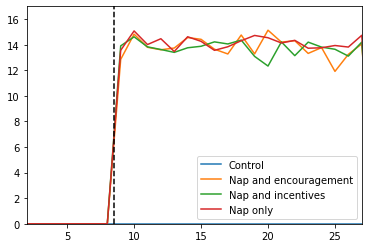

In [70]:
# Crear grupos
d3['group'] = np.where(
    d3['T_nap'].eq(0),
    'Control',
    np.where(
        d3['T_nap'].eq(1) & d3['treatment_group'].eq(0),
        'Nap only',
        np.where(
            d3['T_nap'].eq(1) & d3['treatment_group'].eq(1),
            'Nap and encouragement',
            'Nap and incentives'
        )
    )
)

# Minutos por grupo
t = d3.groupby(['group','day_in_study'])[['nap_time_mins']].mean().fillna(0).reset_index()

# Plot
for g in t['group'].unique():
    # Mask
    m = t['group'].eq(g)

    # Line plot
    plt.plot(t.loc[m, 'day_in_study'], t.loc[m, 'nap_time_mins'], label=g)

plt.axvline(8.5, color='black', ls='--')

# Aesthetics
plt.legend()
plt.xlim(2, 27)
plt.ylim(0, 17)

# Save
if 'google.colab' not in str(get_ipython()):

# Show
plt.show()

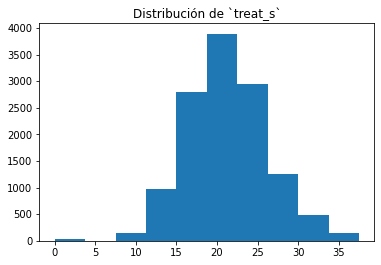

In [59]:
plt.hist(d3['treat_s'])
plt.title('Distribución de `treat_s`')
plt.show()